# OCSMM-SHAP 
## Student grades at school level - Synthetic dataset

In [1]:
import pandas as pd
import numpy as np

# Configuration
n_schools = 30
n_students_per_school = 100  # 100 students per school
subjects = ["Math", "Physics", "History", "English", "Geography", 
            "Art", "Music", "PE", "Chemistry", "Biology"]
n_subjects = 10
np.random.seed(42)
dataset = []

In [2]:
for school_id in range(n_schools):
    # Base grades (mean, std) for each subject
    base_params = np.array([
        [75, 5],   # Math
        [80, 4],   # Physics
        [70, 8],   # History
        [72, 6],   # English
        [68, 7],   # Geography
        [85, 3],   # Art
        [88, 2],   # Music
        [90, 1],   # PE
        [78, 5],   # Chemistry
        [77, 5]    # Biology
    ])
    
    # Generate grades for all students in this school
    school_grades = np.zeros((n_students_per_school, n_subjects))
    for subj_idx in range(n_subjects):
        mean, std = base_params[subj_idx]
        grades = np.random.normal(mean, std, n_students_per_school)
        school_grades[:, subj_idx] = np.clip(grades, 0, 100).astype(int)  # Integer grades
        
    dataset.append(school_grades)


In [3]:
# Anomaly 1: Art grades (column 5) much lower
dataset[29][:, 5] = np.random.randint(20, 40, size=n_students_per_school)

# Anomaly 2: Physics grades (column 1) higher with outliers
physics_grades = np.random.normal(95, 15, n_students_per_school)
dataset[29][:, 1] = np.clip(physics_grades, 0, 100).astype(int)

In [4]:
len(dataset)

30

In [5]:
dataset

[array([[ 77.,  74.,  72.,  67.,  56.,  87.,  89.,  89.,  82.,  78.],
        [ 74.,  78.,  74.,  68.,  63.,  90.,  86.,  91.,  75.,  75.],
        [ 78.,  78.,  78.,  76.,  68.,  80.,  89.,  89.,  78.,  77.],
        [ 82.,  76.,  78.,  75.,  68.,  86.,  90.,  88.,  75.,  83.],
        [ 73.,  79.,  58.,  71.,  64.,  83.,  88.,  88.,  75.,  77.],
        [ 73.,  81.,  62.,  72.,  72.,  83.,  91.,  90.,  76.,  77.],
        [ 82.,  87.,  74.,  79.,  60.,  83.,  86.,  88.,  79.,  70.],
        [ 78.,  80.,  74.,  68.,  67.,  82.,  85.,  91.,  75.,  80.],
        [ 72.,  81.,  74.,  75.,  68.,  85.,  84.,  87.,  84.,  80.],
        [ 77.,  79., 100.,  70.,  71.,  82.,  90.,  91.,  73.,  87.],
        [ 72.,  72.,  74.,  70.,  72.,  85.,  89.,  90.,  77.,  75.],
        [ 72.,  79.,  79.,  78.,  60.,  84.,  87.,  89.,  75.,  78.],
        [ 76.,  80.,  77.,  76.,  57.,  84.,  88.,  89.,  85.,  78.],
        [ 65.,  89.,  75.,  76.,  76.,  82.,  85.,  90.,  78.,  84.],
        [ 66.,  79.,

In [6]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier

In [7]:
classifier = OneClassSMMClassifier(nu=0.1)

In [8]:
classifier.fit(dataset)

Best gamma found.

Kappa matrix calculated.

Found the alphas.



In [9]:
decision, y_pred = classifier.predict(dataset)

Calculating Kappa.

calculating rho.



In [10]:
decision

array([ 0.15845857,  0.15845854,  0.16975645,  0.16153402,  0.16909341,
        0.16361013,  0.164478  ,  0.16640592,  0.16725575,  0.16414402,
        0.16784277,  0.16155419,  0.16179546,  0.15999883,  0.16105384,
        0.15845938,  0.16830633,  0.15845861,  0.16410849,  0.16440834,
        0.16242341,  0.16889926,  0.15845873,  0.15955787,  0.16365502,
        0.16643219,  0.1625267 ,  0.16596838,  0.16074502, -0.79229383])

In [11]:
y_pred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.])

In [12]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[29]

In [13]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=dataset, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=dataset, num_coalitions=2**n_subjects)

Calculating projections: 100%|██████████| 1023/1023 [04:40<00:00,  3.65it/s]


In [14]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [15]:
shapley_values.T

tensor([[ 2.4847e-04,  3.6002e-02,  1.2849e-02,  1.0602e-02,  7.3636e-03,
          3.4040e-02,  1.3884e-02,  1.3033e-02,  1.1056e-02,  2.0666e-02],
        [ 2.8876e-02,  1.1045e-02,  1.4700e-02,  1.6137e-02,  8.1506e-03,
          2.6505e-02,  7.2108e-03,  1.2824e-02,  1.9069e-02,  1.5539e-02],
        [ 3.8937e-03,  3.0316e-02,  1.3724e-02,  1.4383e-02,  2.3122e-02,
          2.7578e-02,  1.3594e-02,  1.2953e-02,  8.3969e-03,  1.9734e-02],
        [ 6.1197e-03,  4.4596e-02,  4.5666e-03,  3.0099e-03,  1.3282e-02,
          3.6333e-02,  1.1054e-02,  1.3842e-02,  1.7206e-02,  1.2276e-02],
        [ 4.2710e-03,  2.6920e-02,  2.3146e-02,  1.7562e-02,  7.1151e-03,
          2.8940e-02,  1.4784e-02,  1.3649e-02,  1.4164e-02,  1.6859e-02],
        [ 1.4913e-02,  2.4018e-02,  1.0751e-02,  2.8044e-02,  1.9948e-02,
          2.1762e-02,  1.3865e-02,  1.3533e-02,  5.6631e-03,  1.1188e-02],
        [ 1.9426e-02,  2.0624e-02,  2.2076e-02,  1.5254e-02,  1.4152e-02,
          1.7588e-02,  1.9390e-0

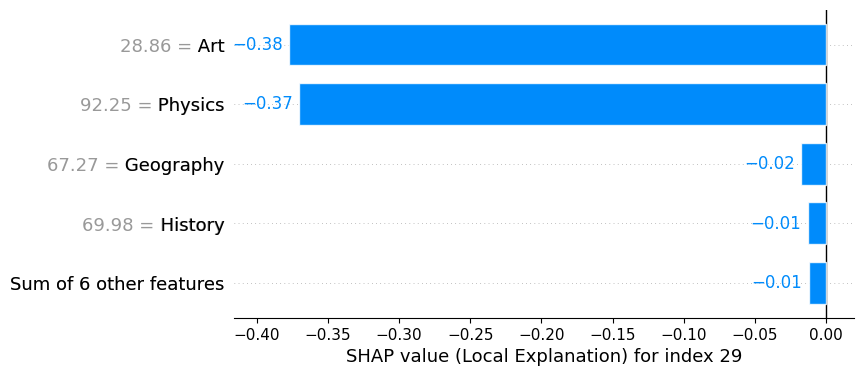

In [16]:
from src.utils.visualisation.deterministic_values import local_bar_plot_ocsmm, global_bar_plot_ocsmm, summary_plot_ocsmm
local_bar_plot_ocsmm(shapley_values.T.numpy(), 29, feature_names=subjects, datasets=dataset)

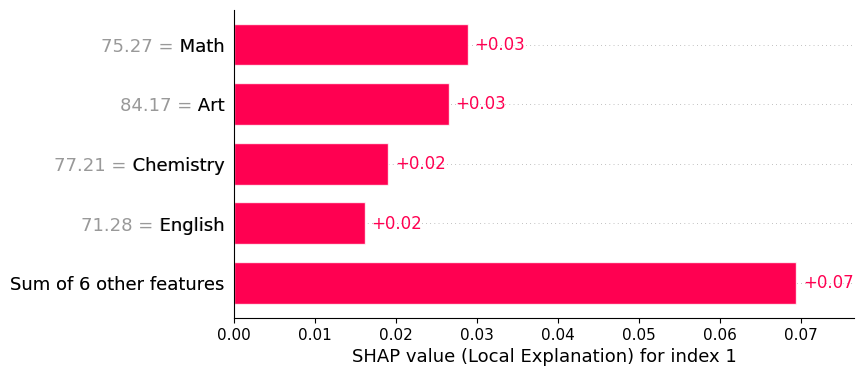

In [17]:
local_bar_plot_ocsmm(shapley_values.T.numpy(), 1, feature_names=subjects, datasets=dataset)

/tmp/ipykernel_3819317/4265259750.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)


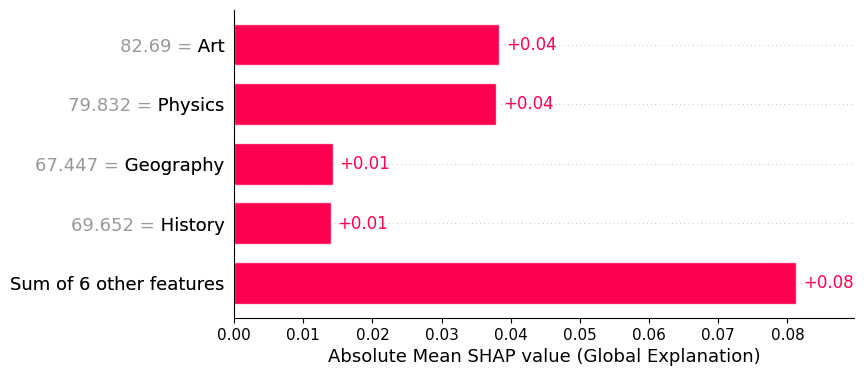

In [18]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_bar_plot_ocsmm(mean_abs_shap_values.numpy(), feature_names=subjects, datasets=dataset)

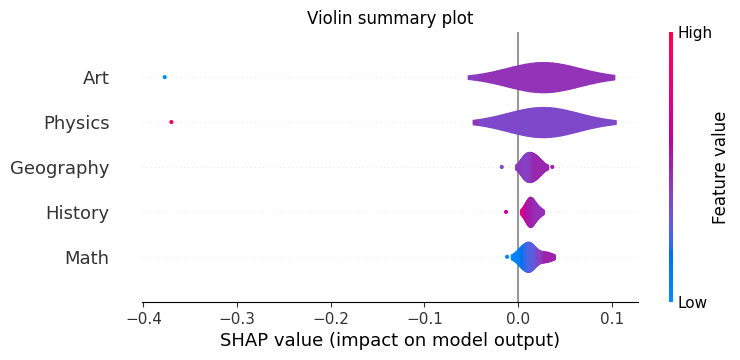

In [19]:
summary_plot_ocsmm(shapley_values.T.numpy(), feature_names=subjects, datasets=dataset)